# Data Modelling

Random Forest Classifier is used to predict the loan repayment (loan status) for each client.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import geopandas as gpd
import altair as alt
from itertools import product
from IPython.display import display, HTML
from boruta import BorutaPy
from statsmodels.graphics.mosaicplot import mosaic

import scipy.stats as stats
from scipy.stats import pearsonr

import plotly.express as px
import plotly.io as pio

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Preprocessing

In [3]:
df = pd.read_csv('cleaned_data.csv')

In [4]:
df.columns

Index(['LoanID', 'HashedSSN', 'PayFrequency', 'APR', 'ApplicationDate',
       'PaidOffCount', 'IsFunded', 'LoanStatus', 'LoanAmount',
       'ScheduledPaymentAmount', 'State', 'LeadType', 'LeadCost',
       'FirstPaymentStatus', 'ClarityFraudID', 'InstallmentIndex',
       'IsCollection', 'Principal', 'Fees', 'PaymentAmount', 'PaymentStatus',
       'CF.inquiry.30_days_ago', 'CF.inquiry.24_hrs_ago',
       'CF.inquiry.1_min_ago', 'CF.inquiry.1_hr_ago', 'CF.inquiry.90_days_ago',
       'CF.inquiry.7_days_ago', 'CF.inquiry.10_mins_ago',
       'CF.inquiry.15_days_ago', 'CF.inquiry.365_days_ago',
       'CF.fs.inq_onf_addr_conflict', 'CF.fs.total_num_fraud_indicators',
       'CF.fs.phone_inconsistent_w_addr', 'CF.fs.inq_age_lt_ssn_date',
       'CF.fs.onf_addr_cautious', 'CF.fs.inq_addr_non_residential',
       'CF.fs.onf_addr_high_risk', 'CF.fs.ssn_frequent_for_another',
       'CF.fs.cur_addr_rep_trade_90_days', 'CF.fs.in_ssn_invalid',
       'CF.fs.in_ssn_date_unverified', 'CF.fs.inq

In [5]:
# Convert to suitable data types
df['CF.fs.phone_inconsistent_w_addr'] = df['CF.fs.phone_inconsistent_w_addr'].astype(object)
df['CF.fs.inq_age_lt_ssn_date'] = df['CF.fs.inq_age_lt_ssn_date'].astype(object)
df['CF.fs.onf_addr_cautious'] = df['CF.fs.onf_addr_cautious'].astype(object)
df['CF.fs.inq_addr_non_residential'] = df['CF.fs.inq_addr_non_residential'].astype(object)
df['CF.fs.onf_addr_high_risk'] = df['CF.fs.onf_addr_high_risk'].astype(object)
df['CF.fs.ssn_frequent_for_another'] = df['CF.fs.ssn_frequent_for_another'].astype(object)
df['CF.fs.cur_addr_rep_trade_90_days'] = df['CF.fs.cur_addr_rep_trade_90_days'].astype(object)
df['CF.fs.in_ssn_invalid'] = df['CF.fs.in_ssn_invalid'].astype(object)
df['CF.fs.in_ssn_date_unverified'] = df['CF.fs.in_ssn_date_unverified'].astype(object)
df['CF.fs.inq_addr_cautious'] = df['CF.fs.inq_addr_cautious'].astype(object)
df['CF.fs.inq_gt_3_in_last_30_days'] = df['CF.fs.inq_gt_3_in_last_30_days'].astype(object)
df['CF.fs.onf_addr_non_residential'] = df['CF.fs.onf_addr_non_residential'].astype(object)
df['CF.fs.credit_prior_ssn_date'] = df['CF.fs.credit_prior_ssn_date'].astype(object)
df['CF.fs.in_ssn_deceased'] = df['CF.fs.in_ssn_deceased'].astype(object)
df['CF.fs.inq_addr_high_risk'] = df['CF.fs.inq_addr_high_risk'].astype(object)
df['CF.fs.inq_current_addr_nof'] = df['CF.fs.inq_current_addr_nof'].astype(object)
df['CF.fs.bof_ssn_date_unverified'] = df['CF.fs.bof_ssn_date_unverified'].astype(object)
df['CF.fs.ssn_belongs_to_another'] = df['CF.fs.ssn_belongs_to_another'].astype(object)

df['CF.fs.bof_ssn_deceased'] = df['CF.fs.bof_ssn_deceased'].astype(object)
df['CF.fs.cur_addr_rep_newtrade_only'] = df['CF.fs.cur_addr_rep_newtrade_only'].astype(object)
df['CF.fs.credit_prior_age_18'] = df['CF.fs.credit_prior_age_18'].astype(object)
df['IsFunded'] = df['IsFunded'].astype(object)

df['CF.fs.inq_onf_addr_conflict'] = df['CF.fs.inq_onf_addr_conflict'].astype(object)
df['IsCollection'] = df['IsCollection'].astype(object)


#### Convert Loan Status into a binary labels (0: Not repaid, 1: Repaid)

In [6]:
repayment_statuses = ['Paid Off Loan', 'Charged Off Paid Off', 'Pending Paid Off', 'Settlement Paid Off']
df['Repayment'] = df['LoanStatus'].apply(lambda status: 1 if status in repayment_statuses else 0)

#### Filter out unique LoanID records with unique HashedSSN, unique PaidOffCount, unique LoanAmount, unique FraudScore, unique ApplicationDate

In [7]:
df = df.drop_duplicates(subset=['LoanID', 'HashedSSN', 'PaidOffCount','LoanAmount','FraudScore','ApplicationDate'], keep='first')

In [8]:
df.head(3)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,PaidOffCount,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID,Repayment
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,0,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,False,151.98,114.49,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64,1
25,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31,2,True,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,False,1250.00,83.75,1333.75,Checked,4,4,1,4,5,4,1,4,10,False,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,partial,unavailable,partial,match,6,835.0,58450a15e4b0bb9d6d7344c7,1
38,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27,0,True,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,False,44.82,142.25,187.07,Checked,13,3,3,3,42,3,3,6,255,False,2,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,match,match,1,624.0,578f9346e4b0810ad5e7b72e,1


In [9]:
df.shape

(26595, 63)

#### Drop unimportant columns

In [10]:
df = df.drop(columns=['LoanID', 'HashedSSN', 'ClarityFraudID', 'UnderwritingID','PaymentAmount','Principal','Fees', 'LoanStatus'])

In [11]:
df.head(3)

,PayFrequency,APR,ApplicationDate,PaidOffCount,IsFunded,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,InstallmentIndex,IsCollection,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,Repayment
0,B,199.0,2016-01-19,0,True,3000.0,6395.19,CA,prescreen,0,Checked,1,False,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,1
25,S,490.0,2017-01-31,2,True,1250.0,3313.78,MO,organic,0,Checked,1,False,Checked,4,4,1,4,5,4,1,4,10,False,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,partial,unavailable,partial,match,6,835.0,1
38,B,590.0,2016-08-27,0,True,800.0,2432.08,CA,bvMandatory,10,Checked,1,False,Checked,13,3,3,3,42,3,3,6,255,False,2,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,match,match,1,624.0,1


#### Label encode the dataset

In [12]:
le = LabelEncoder()
le_dict = dict()
cat_vars = df.select_dtypes(object).columns.values.tolist()
for var in cat_vars:
    df[var] = le.fit_transform(df[var])
    le_dict[var] = le.classes_.tolist()

display(df.head(3))

,PayFrequency,APR,ApplicationDate,PaidOffCount,IsFunded,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,InstallmentIndex,IsCollection,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,Repayment
0,0,199.0,324,0,1,3000.0,6395.19,3,5,0,1,1,0,1,3,3,3,3,3,3,3,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1,0,3,0,5,879.0,1
25,3,490.0,700,2,1,1250.0,3313.78,19,4,0,1,1,0,1,4,4,1,4,5,4,1,4,10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0,0,3,4,3,1,6,835.0,1
38,0,590.0,543,0,1,800.0,2432.08,3,0,10,1,1,0,1,13,3,3,3,42,3,3,6,255,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1,4,0,1,1,624.0,1


## Feature Selection

##### Rank Features

In [13]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order * np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

In [14]:
def get_scores(n, feature_selector):
    scores = ranking(list(map(float, feature_selector.ranking_)), colnames, order=-1)
    scores = pd.DataFrame(list(scores.items()), columns=["Features", "Score"])
    scores = scores.sort_values("Score", ascending=False)
    return scores.head(n).reset_index(drop=True)

In [15]:
def train_fs(fs, X, y, n):
    fs.fit(X.values, y.values.ravel())
    print(fs)
    return get_scores(n, fs)


def create_Boruta_fs(model, X, y, n):
    fs = BorutaPy(model, n_estimators="auto", max_iter=10)
    return train_fs(fs, X, y, n)

def create_RFE_fs(model, X, y, n):
    fs = RFECV(model, n_jobs=-1, cv=3)
    return train_fs(fs, X, y, n)

def create_Boruta_clf_fs(X, y, n, **kargs):
    clf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", **kargs)
    return create_Boruta_fs(clf, X, y, n)

def create_RFE_clf_fs(X, y, n, **kargs):
    clf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", **kargs)
    return create_RFE_fs(clf, X, y, n)

In [16]:
def display_features(top_features):
    df_features = pd.DataFrame()
    for k in top_features.keys():
        df_features = pd.concat([df_features, pd.DataFrame(top_features[k])], axis=1)
    df_features.columns = pd.MultiIndex.from_tuples(
            list(product(top_features.keys(), ["Feature", "Score"])))
    display(df_features)
    return df_features

def combine_all_top_features(df_features):
    return list(set(np.ravel(df_features.filter(like="Feature", axis=1).values.tolist())))

In [17]:
n = 10

top_clf_features = dict()

In [18]:
targeted_variable = "Repayment" 

X = df.drop(columns=[targeted_variable])
y = df[targeted_variable]
colnames = X.columns

np.int = np.int32
np.float = np.float64
np.bool = np.bool_



#BORUTA
features = create_Boruta_clf_fs(X, y, n, criterion="gini")
top_clf_features["boruta_cri_gini"] = features

features = create_Boruta_clf_fs(X, y, n, criterion="entropy")
top_clf_features["boruta_cri_entropy"] = features

features = create_Boruta_clf_fs(X, y, n, criterion="log_loss")
top_clf_features["boruta_cri_log_loss"] = features



#RFE
features = create_RFE_clf_fs(X, y, n, criterion="gini")
top_clf_features["rfe_cri_gini"] = features

features = create_RFE_clf_fs(X, y, n, criterion="entropy")
top_clf_features["rfe_cri_entropy"] = features

features = create_RFE_clf_fs(X, y, n, criterion="log_loss")
top_clf_features["rfe_cri_log_loss"] = features


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=34, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x107936240),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x107936240)
BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          criterion='entropy', n_estimators=28,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x107936240),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x107936240)
BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          criterion='log_loss', n_estimators=31,
                                          n_jobs=-1,
                                          random_state=RandomState(MT199

In [19]:
df_top_clf_features = display_features(top_clf_features)
selected_clf_features = combine_all_top_features(df_top_clf_features)
selected_clf_features

boruta_cri_gini             boruta_cri_entropy        \
                   Feature Score                  Feature Score   
0               FraudScore  1.00               FraudScore  1.00   
1   ScheduledPaymentAmount  1.00   ScheduledPaymentAmount  1.00   
2          ApplicationDate  1.00          ApplicationDate  1.00   
3            PaymentStatus  1.00       FirstPaymentStatus  0.98   
4       FirstPaymentStatus  1.00            PaymentStatus  0.96   
5                      APR  0.98                      APR  0.94   
6  CF.inquiry.365_days_ago  0.96  CF.inquiry.365_days_ago  0.92   
7                    State  0.93                    State  0.90   
8                 LeadCost  0.91   CF.inquiry.90_days_ago  0.88   
9   CF.inquiry.90_days_ago  0.89               LoanAmount  0.85   

       boruta_cri_log_loss                            rfe_cri_gini        \
                   Feature Score                           Feature Score   
0               FraudScore  1.00                      PayFrequency   1.0   
1   ScheduledPaymentAmount  1.00             CF.inquiry.24_hrs_ago   1.0   
2          ApplicationDate  1.00           CF.match.oa_reason_code   1.0   
3       FirstPaymentStatus  0.98                CF.match.name_addr   1.0   
4            PaymentStatus  0.96              CF.fs.max_num_ssn_ba   1.0   
5                      APR  0.94                               APR   1.0   
6  CF.inquiry.365_days_ago  0.92  CF.fs.total_num_fraud_indicators   1.0   
7                    State  0.90           CF.inquiry.365_days_ago   1.0   
8   CF.inquiry.90_days_ago  0.88            CF.inquiry.15_days_ago   1.0   
9               LoanAmount  0.85            CF.inquiry.10_mins_ago   1.0   

                    rfe_cri_entropy                        rfe_cri_log_loss  \
                            Feature Score                           Feature   
0                      PayFrequency   1.0                      PayFrequency   
1          CF.fs.inq_addr_high_risk   1.0                               APR   
2                               APR   1.0            CF.inquiry.10_mins_ago   
3    CF.fs.inq_addr_non_residential   1.0            CF.inquiry.15_days_ago   
4          CF.fs.onf_addr_high_risk   1.0           CF.inquiry.365_days_ago   
5    CF.fs.ssn_frequent_for_another   1.0       CF.fs.inq_onf_addr_conflict   
6  CF.fs.cur_addr_rep_trade_90_days   1.0  CF.fs.total_num_fraud_indicators   
7      CF.fs.in_ssn_date_unverified   1.0   CF.fs.phone_inconsistent_w_addr   
8           CF.fs.inq_addr_cautious   1.0    CF.fs.inq_addr_non_residential   
9    CF.fs.inq_gt_3_in_last_30_days   1.0            CF.inquiry.90_days_ago   

         
  Score  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  
5   1.0  
6   1.0  
7   1.0  
8   1.0  
9   1.0

['LeadCost',
 'CF.fs.inq_addr_cautious',
 'CF.fs.phone_inconsistent_w_addr',
 'CF.match.oa_reason_code',
 'CF.fs.onf_addr_high_risk',
 'CF.fs.cur_addr_rep_trade_90_days',
 'CF.fs.total_num_fraud_indicators',
 'ScheduledPaymentAmount',
 'CF.fs.inq_gt_3_in_last_30_days',
 'CF.fs.max_num_ssn_ba',
 'CF.fs.in_ssn_date_unverified',
 'State',
 'APR',
 'PayFrequency',
 'CF.inquiry.90_days_ago',
 'ApplicationDate',
 'FirstPaymentStatus',
 'CF.inquiry.10_mins_ago',
 'CF.fs.inq_addr_non_residential',
 'FraudScore',
 'CF.inquiry.365_days_ago',
 'PaymentStatus',
 'LoanAmount',
 'CF.inquiry.24_hrs_ago',
 'CF.match.name_addr',
 'CF.fs.ssn_frequent_for_another',
 'CF.fs.inq_onf_addr_conflict',
 'CF.inquiry.15_days_ago',
 'CF.fs.inq_addr_high_risk']

## Classification Model

**Goal: Predict the loan repayment**

In [20]:
selected_clf_features = ['LeadCost',
                         'CF.fs.inq_addr_cautious',
                         'CF.fs.phone_inconsistent_w_addr',
                         'CF.match.oa_reason_code',
                         'CF.fs.onf_addr_high_risk',
                         'CF.fs.cur_addr_rep_trade_90_days',
                         'CF.fs.total_num_fraud_indicators',
                         'ScheduledPaymentAmount',
                         'CF.fs.inq_gt_3_in_last_30_days',
                         'CF.fs.max_num_ssn_ba',
                         'CF.fs.in_ssn_date_unverified',
                         'State',
                         'APR',
                         'PayFrequency',
                         'CF.inquiry.90_days_ago',
                         'ApplicationDate',
                         'FirstPaymentStatus',
                         'CF.inquiry.10_mins_ago',
                         'CF.fs.inq_addr_non_residential',
                         'FraudScore',
                         'CF.inquiry.365_days_ago',
                         'PaymentStatus',
                         'LoanAmount',
                         'CF.inquiry.24_hrs_ago',
                         'CF.match.name_addr',
                         'CF.fs.ssn_frequent_for_another',
                         'CF.fs.inq_onf_addr_conflict',
                         'CF.inquiry.15_days_ago',
                         'CF.fs.inq_addr_high_risk']


X = df[selected_clf_features]
y = df["Repayment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_models = dict()

In [21]:
model = RandomForestClassifier()
print(model.get_params())

params = {"max_depth": [2, 3, 4],
          "min_samples_leaf": [0.04, 0.06],
          "max_features": [0.2, 0.4, 0.6, 0.8]}

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring='accuracy',
                    cv=10,
                    verbose=3,
                    n_jobs=-1)

grid.fit(X_train, y_train)

best_hyperparams = grid.best_params_
print(f"Best hyperparameters:\n{best_hyperparams}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best hyperparameters:
{'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 0.04}


In [22]:
clf_models["rf"] = grid.best_estimator_
clf_models

{'rf': RandomForestClassifier(max_depth=4, max_features=0.6, min_samples_leaf=0.04)}

## Model Evaluation

In [23]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = [], []

for name, model in clf_models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(f"{name:8} Mean MSE: {-np.mean(scores):.3f}, Std: {np.std(scores):.3f}")


best_model = clf_models['rf'] 

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rf       Mean MSE: 0.275, Std: 0.007


In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [26]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.72
Precision: 0.61
Recall: 0.53
F1 Score: 0.57


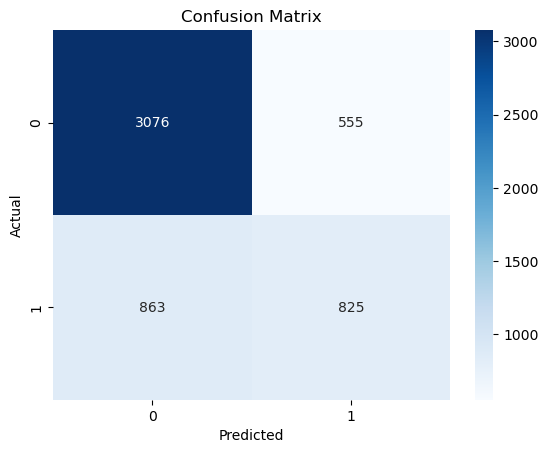

In [45]:
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()